In [1]:
%reset -f

In [2]:
import pandas as pd
import csv
import pickle
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
import os

from stage1 import lasso_rolling_window, create_lagged_features, get_coefficient_dataframe, analyze_results
from stage2 import estimate_kappa

In [3]:
base_dir = Path(os.getenv("LASSO_OUTPUT_DIR", "output"))

In [4]:
features_path = Path("output") / "features.pkl"
response_path = Path("output") / "response.pkl"
return_path = Path("data") / "return84_20.csv"

with features_path.open("rb") as f:
    X = pickle.load(f)
    
with response_path.open("rb") as f:
    y = pickle.load(f)

if not return_path.exists():
    return_path = Path(r"C:\Users\jonat\Lasso_paper\Empirical\data\return84_20.csv")
    print("Using absolute path:", return_path)


Using absolute path: C:\Users\jonat\Lasso_paper\Empirical\data\return84_20.csv


In [5]:
y = np.log(y+1)

In [6]:
# # Cross-validated lambda
# res_cv = lasso_rolling_window(X, y, window_size=60, n_lags=3, lambda_mode="cv", cv_folds=5)
# # Fixed lambda
# res_fixed = lasso_rolling_window(X, y, window_size=60, n_lags=3,
#                                  lambda_mode="fixed", fixed_lambda=0.0005)

In [7]:

# # Access results
# lambdas = res_fixed['lambdas']
# coefficients = res_fixed['coefficients']

In [8]:
# df_coefs = get_coefficient_dataframe(results)
# analysis = analyze_results(results)

### We now estimated the 1st stage under the assumption that the agents PLM is estimated by LASSO.

The next step is now to use these forecasted returns to estimate the ALM.
The ALM in the 2nd stage is specified as: 

$$
r_{t+1} = \log(\varepsilon_{t+1}) 
+ \log(1 - \kappa e^{x'_t \beta}) 
- \log(1 - \kappa e^{x'_{t+1} \beta})
$$

$$
\kappa := \delta a^{-\gamma} \phi
$$

Here, $x'_t \beta$ and $x'_{t+1} \beta$ are the $t$ and $t+1$ return foreacsts of the agent from the 1st stage.

In [9]:
# # Create a DataFrame of predictions indexed by date
# stage2 = (
#     pd.DataFrame({
#         "predictions": results["predictions"]
#     }, index=pd.to_datetime(results["prediction_dates"]))
# )

# # Ensure returns index is datetime and join
# returns.index = pd.to_datetime(returns["DATE"])
# stage2 = returns.join(stage2, how='inner')

# # # Compute residuals (epsilon)
# stage2["epsilon"] = stage2["vwretd"] - stage2["predictions"]



Running rolling LASSO for lambda = 0.000001 ...


Rolling windows: 100%|██████████| 8407/8407 [02:46<00:00, 50.42it/s]



Running rolling LASSO for lambda = 0.000316 ...


Rolling windows: 100%|██████████| 8407/8407 [00:21<00:00, 389.08it/s]



Running rolling LASSO for lambda = 0.100000 ...


Rolling windows: 100%|██████████| 8407/8407 [00:06<00:00, 1240.74it/s]
/var/folders/hb/bc0srnt52zx6lbw4t2k_t_k80000gn/T/ipykernel_4404/435919071.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  kappa_tstat = kappa_est / kappa_se



=== Kappa & Avg Active Predictors by Lambda ===
     lambda         kappa   kappa_tstat  intercept  intercept_tstat  \
0  0.000001  8.558605e-10  8.110954e-08   0.000409         3.447961   
1  0.000316  2.161846e-11  1.928642e-09   0.000409         3.447961   
2  0.100000  8.000000e-01           inf   0.000409         3.448600   

   avg_active_predictors  insample_r_squared  r_squared_stage_1  phi_stage_1  \
0              76.317236            0.965235      -6.390280e-01     1.000097   
1              26.019864            0.946543      -5.074336e-01     1.000089   
2               0.000000           -0.034765      -6.349927e-07     1.000059   

   r_squared_stage_2  
0      -6.395351e-11  
1      -8.408829e-13  
2      -4.862089e-11  


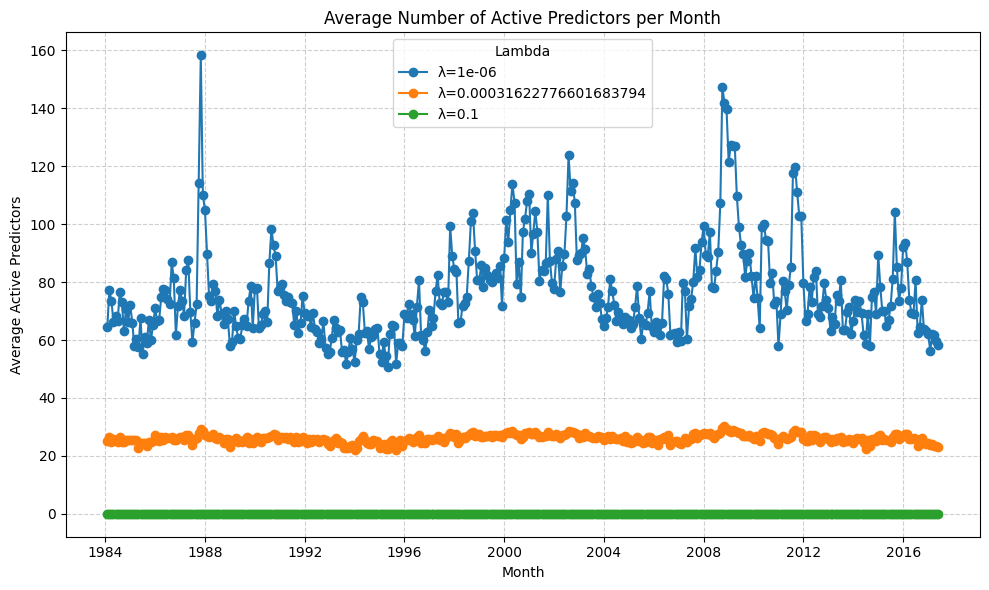

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stage1 import lasso_rolling_window
from stage2 import estimate_kappa, estimate_kappa_curve_fit

# --- Inputs (already created) ---
# X: np.ndarray of features
# y: np.ndarray of response variable (e.g., returns)
lambda_values = np.logspace(-6, -1, 3)

# lambda_values = [0.1, 0.01, 0.001, 0.0001, 0.0005, 0.00001]  # Example grid
results_summary = []
active_predictors_all = []
alm_returns_all = []  # NEW: store realized ALM returns
stage_1_results = {}

# === Helper: Compute ALM-implied realized returns ===
def compute_alm_returns(stage2_df, kappa, intercept):
    """
    Compute realized returns implied by the ALM:
    r_hat_{t+1} = log(eps_{t+1}) + log(1 - kappa * exp(pred_t)) - log(1 - kappa * exp(pred_{t+1}))
    """
    
    pred_t = stage2_df["predictions"].values[:-1]
    pred_t1 = stage2_df["predictions"].values[1:]

    valid = (1 - kappa * np.exp(pred_t) > 0) & (1 - kappa * np.exp(pred_t1) > 0)
    if not np.all(valid):
        # If invalid, truncate to valid portion only
        valid_idx = np.where(valid)[0]
        pred_t, pred_t1 = pred_t[valid_idx], pred_t1[valid_idx + 1]

    r_hat = np.log(1 - kappa * np.exp(pred_t)) - np.log(1 - kappa * np.exp(pred_t1)) + intercept
    return pd.Series(r_hat, name="r_hat")

# === Main Loop ===
for lam in lambda_values:
    print(f"\nRunning rolling LASSO for lambda = {lam:.6f} ...")

    # Step 1: Rolling LASSO
    lasso_results = lasso_rolling_window(
        X=X,
        y=y,
        window_size=30,
        n_lags=3,
        lambda_mode="fixed",
        fixed_lambda=lam,
        verbose=False
    )

    # Step 2: Compute residuals
    preds = np.array(lasso_results["predictions"])
    y_valid = y[-len(preds):] if not isinstance(y, pd.Series) else y.iloc[-len(preds):]
    u = y_valid.values - preds if isinstance(y_valid, pd.Series) else y_valid - preds

    #compute r_squared
    ss_total = np.sum((y_valid - np.mean(y_valid))**2)
    ss_residual = np.sum(u**2)
    r_squared = 1 - (ss_residual / ss_total)

    # Compute variance of residuals 
    sigma_u2 = np.var(u)
    # Compute phi
    phi = np.exp(0.5 * sigma_u2)

      #report in-sample r-squared
    insample_r2 = np.mean(lasso_results['insample_r_squareds'])
    #Compute the r-squared of stage 1
    stage_1_results[lam] = {
        "r_squared": r_squared,
        "phi": phi,
        "insample_r_squared": insample_r2
    }

  


    stage2_input = pd.DataFrame({
        "vwretd": np.asarray(y_valid),
        "predictions": preds
    })

    # Step 3: Estimate kappa
    try:
        popt, pcov = estimate_kappa_curve_fit(stage2_input)
        kappa_est = popt[0]
        intercept_est = popt[1]
        #t-stat
        kappa_se = np.sqrt(np.diag(pcov))[0]
        kappa_tstat = kappa_est / kappa_se
        intercept_se = np.sqrt(np.diag(pcov))[1]
        intercept_tstat = intercept_est / intercept_se
        
    except Exception as e:
        print(f"⚠️ Kappa estimation failed for λ={lam:.6f}: {e}")
        kappa_est, intercept_est = np.nan, np.nan
        kappa_tstat, intercept_tstat = np.nan, np.nan

    # Step 4: Active predictors per rolling window
    coefs = np.array(lasso_results["coefficients"])
    active_counts = np.count_nonzero(coefs, axis=1)

    if "window_end_dates" in lasso_results:
        dates = pd.to_datetime(lasso_results["window_end_dates"])
    else:
        dates = pd.RangeIndex(len(active_counts))

    active_df = pd.DataFrame({
        "date": dates,
        "active_predictors": active_counts,
        "lambda": lam
    })
    active_predictors_all.append(active_df)

    avg_active = np.mean(active_counts)

    # --- NEW: Compute ALM-implied realized returns and get second stage r-squared
    if np.isfinite(kappa_est):
        alm_returns = compute_alm_returns(stage2_input, kappa_est, intercept_est)
        if isinstance(y_valid, pd.Series):
            alm_returns.index = y_valid.index[1:len(alm_returns)+1]
        alm_df = pd.DataFrame({
            "date": alm_returns.index,
            "r_hat": alm_returns.values,
            "lambda": lam
        })
        alm_returns_all.append(alm_df)
        #get second stage r-squared
        stage_2_tss = np.sum((stage2_input["vwretd"].values[1:] - np.mean(stage2_input["vwretd"].values[1:]))**2)
        stage_2_rss = np.sum((stage2_input["vwretd"].values[1:] - alm_returns.values)**2)
        stage_2_r_squared = 1 - (stage_2_rss / stage_2_tss)
    else:
        stage_2_r_squared = np.nan

    results_summary.append({
        "lambda": lam,
        "kappa": kappa_est,
        "kappa_tstat": kappa_tstat,
        "intercept": intercept_est,
        "intercept_tstat": intercept_tstat,
        "avg_active_predictors": avg_active,
        "insample_r_squared": insample_r2,
        "r_squared_stage_1": stage_1_results[lam]["r_squared"],
        "phi_stage_1": stage_1_results[lam]["phi"],
        "r_squared_stage_2": stage_2_r_squared
    })

# --- Summary Table ---
results_df = pd.DataFrame(results_summary)
print("\n=== Kappa & Avg Active Predictors by Lambda ===")
print(results_df)

# --- Combine Active Predictor Data ---
active_predictors_df = pd.concat(active_predictors_all, ignore_index=True)

# --- Combine ALM-implied returns ---
if alm_returns_all:
    alm_returns_long = pd.concat(alm_returns_all, ignore_index=True)
    # Pivot to wide: date index, columns = lambda values
    alm_returns_df = (
        alm_returns_long
        .pivot(index="date", columns="lambda", values="r_hat")
        .sort_index()
    )
else:
    alm_returns_df = None


# === Plot 1: Active Predictors (monthly) ===
if pd.api.types.is_datetime64_any_dtype(active_predictors_df["date"]):
    active_predictors_df["month"] = active_predictors_df["date"].dt.to_period("M").dt.to_timestamp()
    monthly_avg = (
        active_predictors_df
        .groupby(["lambda", "month"])["active_predictors"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    for lam in lambda_values:
        subset = monthly_avg[monthly_avg["lambda"] == lam]
        plt.plot(subset["month"], subset["active_predictors"], marker="o", label=f"λ={lam}")
    plt.title("Average Number of Active Predictors per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Active Predictors")
    plt.legend(title="Lambda")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ y has no datetime index — cannot create monthly time series plot.")


In [11]:
print(stage2_input["predictions"].describe())
print(np.exp(stage2_input["predictions"]).max())


count    8.406000e+03
mean     3.989940e-04
std      5.421333e-20
min      3.989940e-04
25%      3.989940e-04
50%      3.989940e-04
75%      3.989940e-04
max      3.989940e-04
Name: predictions, dtype: float64
1.000399073587612


In [12]:
print(np.mean(alm_returns_all[0]["r_hat"]))

0.0004085128716878346


In [13]:
print(alm_returns_df.mean())


lambda
0.000001    0.000409
0.000316    0.000409
0.100000    0.000409
dtype: float64
